# NLP Practical example: Simple Sentiment Analysis model 

Let's build a complete sentiment analysis system from scratch! We'll classify movie reviews as positive or negative.

In [64]:
import re
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import os
import kagglehub

## Step 1: Data Preparation

For this example, we'll create a small dataset.

In practice, you'd use datasets like [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [65]:
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

data_path = os.path.join(path, "IMDB Dataset.csv")

df = pd.read_csv(data_path)

In [66]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Data Exaploration

In [67]:
df.shape

(50000, 2)

In [68]:
# check sentiment distribution
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [69]:
# check for missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

## Step 2: Text Preprocessing

In [70]:
# Run this cell only once to download NLTK resources
nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ivelindzhangarov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ivelindzhangarov/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivelindzhangarov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivelindzhangarov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [71]:
def preprocess_text(text):
    """
    Complete text preprocessing pipeline

    Args:
        text (str): Raw text input

    Returns:
        str: Cleaned and processed text
    """
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Tokenize into words
    tokens = word_tokenize(text)

    # 4. Remove stopwords (but keep negations!)
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'neither', 'never'}
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization (reduce words to base form)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 6. Join tokens back into string
    return ' '.join(tokens)

# Apply preprocessing to the reviews
df['cleaned_review'] = df['review'].apply(preprocess_text)
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching 1 oz episode y...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


## Step 3: Split Data

In [72]:
# Split features and labels
X = df['cleaned_review']
y = df['sentiment']

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 40000
Test set size: 10000


## Step 4: Vectorization

In [170]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# Fit on training data and transform both sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training matrix shape: {X_train_tfidf.shape}")
print(f"Test matrix shape: {X_test_tfidf.shape}")

Training matrix shape: (40000, 7167459)
Test matrix shape: (10000, 7167459)


## Step 5: Train Model

In [ ]:
# Train Logistic Regression classifier
model = LogisticRegression(max_iter=1500, solver='liblinear', fit_intercept=False)
model.fit(X_train_tfidf, y_train)

print("Model trained successfully!")

Model trained successfully!


In [202]:
model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,False
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,1500
,multi_class,'deprecated'


### Feature Importance Analysis

We can get the most important features from model coeffcients.

Model coefficients are a measure of how much a feature contributes to the classification score.

The most important features are those with the largest absolute coefficients.

- Large Positive Coefficients → Features strongly indicating Positive Sentiment (Class 1).
- Large Negative Coefficients → Features strongly indicating Negative Sentiment (Class 0).

In [203]:
# Get the model coefficients
# We take the first row [0] because it's a binary classification problem.
coefficients = model.coef_[0]

# Create a Series to map coefficients to feature names
feature_names = vectorizer.get_feature_names_out()
coef_df = pd.Series(coefficients, index=feature_names)

In [204]:
## Top 10 Features Indicating POSITIVE Sentiment
print("--- Top 10 Features for POSITIVE Sentiment (Highest Coefficients) ---")
# .nlargest(10) gets the largest positive coefficients
top_positive = coef_df.nlargest(10)
print(top_positive)

print("\n" + "="*50 + "\n")

## Top 10 Features Indicating NEGATIVE Sentiment
print("--- Top 10 Features for NEGATIVE Sentiment (Lowest Coefficients) ---")
# .nsmallest(10) gets the largest negative coefficients
top_negative = coef_df.nsmallest(10)
print(top_negative)

--- Top 10 Features for POSITIVE Sentiment (Highest Coefficients) ---
great        12.520304
excellent     8.098177
best          7.644988
love          7.131171
wonderful     6.087934
well          6.044028
perfect       5.807456
loved         5.558508
amazing       5.466193
life          5.202591
dtype: float64


--- Top 10 Features for NEGATIVE Sentiment (Lowest Coefficients) ---
bad        -13.687738
worst      -11.078398
awful       -8.172028
waste       -7.792927
no          -7.299232
boring      -7.117527
nothing     -7.083922
terrible    -6.899300
poor        -6.743748
even        -6.070079
dtype: float64


## Evaluate Model

In [205]:
# Make predictions to evaluate the model
y_pred = model.predict(X_test_tfidf)

### Calculate accuracy

In [206]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4%}")


Accuracy: 88.8400%


### Detailed classification report

The report provides four main metrics for each class: Precision, Recall, F1-Score, and Support.

1. Precision

Precision measures the proportion of a model's positive predictions that are correct, calculated as \(TruePositives/(TruePositives+FalsePositives)\)
- The ability of the classifier not to label as positive a sample that is negative. In simple terms, out of all the instances the model predicted as a certain class (e.g., 'Negative'), how many were actually correct?

2. Recall (or Sensitivity)

- The ability of the classifier to find all the positive samples. In simple terms, out of all the instances that truly belong to a certain class (e.g., 'Negative'), how many did the model correctly identify?

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.74      0.74      0.74      5000
    Positive       0.74      0.73      0.74      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



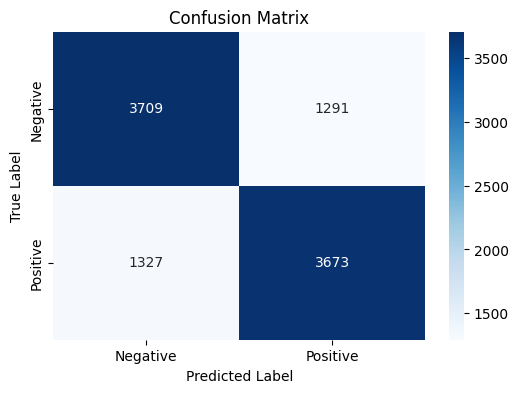

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()